In [35]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns

In [20]:
num_classes = 10
num_features = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

In [19]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [24]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    self.output_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    x = self.layer1(x)
    x = tf.nn.relu(x)
    x = self.layer2(x)
    x = tf.nn.relu(x)
    x = self.output_layer(x, activation=1)
    return x

In [23]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1, output_type=tf.int32)
    correct_predictions = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [25]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.output_layer.w, neural_net.output_layer.b]
    gradients = g.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [36]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

InvalidArgumentError: cannot compute Equal as input #1(zero-based) was expected to be a int32 tensor but is a uint8 tensor [Op:Equal] name: 

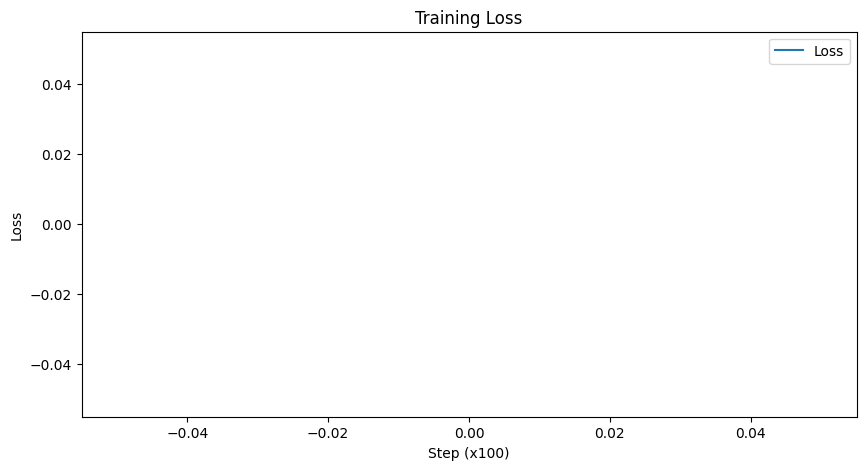

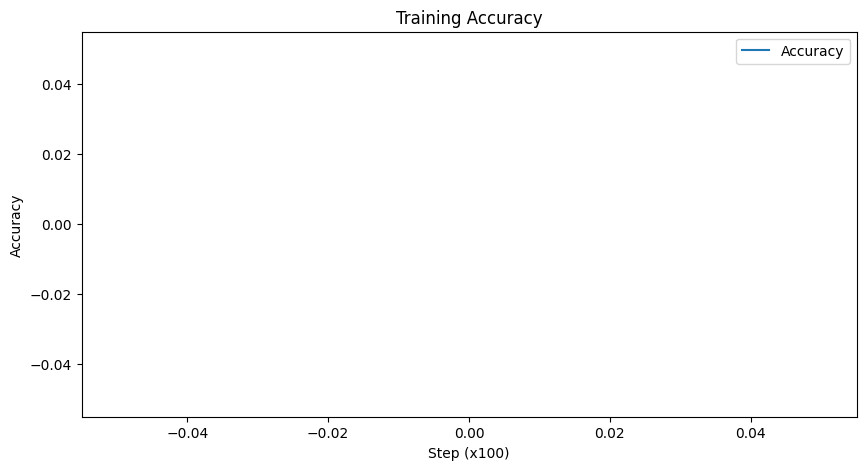

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Step (x100)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.xlabel('Step (x100)')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [32]:
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8124


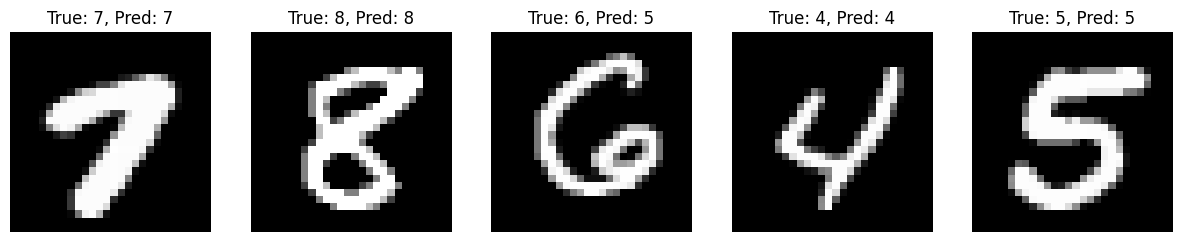

In [33]:
indices = random.sample(range(x_test.shape[0]), 5)
sample_images = x_test[indices]
sample_labels = y_test[indices]

predictions = tf.argmax(neural_net(sample_images), axis=1)

plt.figure(figsize=(15, 5))
for i, (image, label, pred) in enumerate(zip(sample_images, sample_labels, predictions)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"True: {label}, Pred: {pred}")
    plt.axis('off')
plt.show()